In [1]:
%run ./PPS_Expansion_Model.ipynb

/home/renato/.virtualenvs/pps/lib/python3.11/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
/tmp/ipykernel_58912/1247435164.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


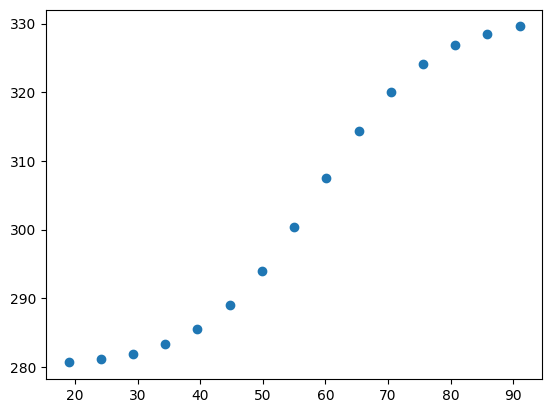

In [2]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
mydistances = 100 - ts * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###Healthy Controls
ymin = 280
ymax = 331
fprHCCP = 100 - 1.377 * v
fprHCS = 1 / 0.11  # negative

HC_RTs = RTsig(mydistances, fprHCCP, fprHCS)
plt.scatter(mydistances, HC_RTs)

In [3]:
from scipy.optimize import differential_evolution

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)


def boundaryhcmodelrun(theta):
    HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
        6.5, 6.5, 6.5, 6.55, 6.55, 6.55, theta[0], theta[1], theta[2], theta[3]
    )  # feedforward and feedback
    _, _, _, _, HCrt = experiment(
        ts,
        simtime,
        mydistances,
        5,
        HCLt,
        HCLa,
        HCLv,
        HCWt,
        HCWa,
        HCWv,
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        0,
        0,
    )

    xf = HCrt
    yf = HC_RTs

    m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
        xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
    )
    bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

    if bias < 0:
        bias = 0
    if m < 0:
        m = 0

    cost = np.sum(np.square(np.divide(yf - (m * xf + bias), yf)))

    return cost * 100000


bounds = [(1, 50), (500, 1000), (20, 80), (0.25, 1)]  # k1, k2, lim, alpha
boundaryhcres = differential_evolution(
    boundaryhcmodelrun, bounds, disp=True, workers=-1, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 33.71401922300286
differential_evolution step 2: f(x)= 14.471197576101881
differential_evolution step 3: f(x)= 14.471197576101881
differential_evolution step 4: f(x)= 14.471197576101881
differential_evolution step 5: f(x)= 11.07782318447258
differential_evolution step 6: f(x)= 11.07782318447258
differential_evolution step 7: f(x)= 11.07782318447258
differential_evolution step 8: f(x)= 11.07782318447258
differential_evolution step 9: f(x)= 11.07782318447258
differential_evolution step 10: f(x)= 10.901958130964392
differential_evolution step 11: f(x)= 9.182796991648082
differential_evolution step 12: f(x)= 9.182796991648082
differential_evolution step 13: f(x)= 8.65326458081516
differential_evolution step 14: f(x)= 5.703324978716624
differential_evolution step 15: f(x)= 5.703324978716624
differential_evolution step 16: f(x)= 5.703324978716624
differential_evolution step 17: f(x)= 5.703324978716624
differential_evolution step 18: f(x)= 5.70332497871662

In [5]:
print(boundaryhcres)

             message: Optimization terminated successfully.
             success: True
                 fun: 5.0960027804809025
                   x: [ 1.083e+01  5.076e+02  3.226e+01  9.968e-01]
                 nit: 135
                nfev: 8160
          population: [[ 1.083e+01  5.076e+02  3.226e+01  9.968e-01]
                       [ 1.083e+01  5.898e+02  3.226e+01  9.969e-01]
                       ...
                       [ 1.083e+01  5.485e+02  3.225e+01  9.969e-01]
                       [ 1.083e+01  5.651e+02  3.225e+01  9.969e-01]]
 population_energies: [ 5.096e+00  5.096e+00 ...  5.096e+00  5.096e+00]


In [7]:
## Fitted model

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)
_, _, _, _, HC_Model_RTs = experiment(
    0.4,
    200,
    mydistances,
    5,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

HC_Model_RTs = fit_RT(HC_Model_RTs, HC_RTs)

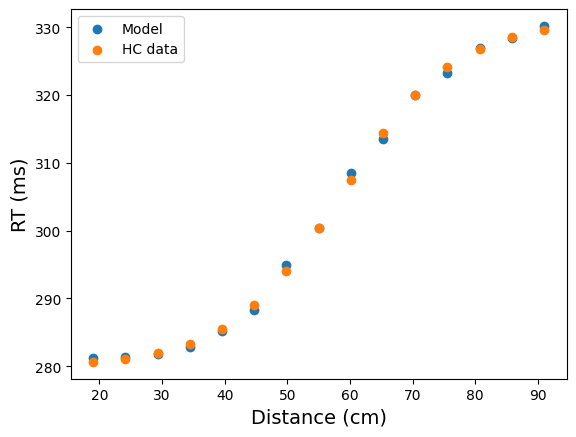

In [8]:
plt.scatter(mydistances, HC_Model_RTs, label="Model")
plt.scatter(mydistances, HC_RTs, label="HC data")
plt.ylabel("RT (ms)", size=14)
plt.xlabel("Distance (cm)", size=14)
plt.legend(prop={"size": 12})
plt.legend()